# Parallel processing with spark


The objectives of this notebook, firstly, to find a method for determining the related components of a graph in a very simple case. Secondly, to reproduce the same work on a partitioned graph (initially with 2 partitions), then with several partitions on real data, while parallelizing the processing using Spark tools. 

#### Install Pyspark

In [3]:
!pip install -q pyspark
!pip install -q findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


#### Install igraph

In [4]:
!pip install -q igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 10.3 MB/s eta 0:00:00


In [5]:
import numpy as np
import igraph as ig
import networkx as nx

#### Start a spark session

In [6]:
import os
import glob

pyspark_dir = glob.glob('/usr/local/lib/python*/dist-packages/pyspark')[0]
print("pyspark directory is", pyspark_dir)
os.environ["SPARK_HOME"] = pyspark_dir
os.environ["JAVA_HOME"] = "/usr"

pyspark directory is /usr/local/lib/python3.10/dist-packages/pyspark


In [7]:
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

from pyspark.sql import *

import pyspark.sql.functions as f
from pyspark.sql.functions import col

from pyspark.sql.types import *
from datetime import *

import time

findspark.init()

# --------------------------
def demarrer_spark():
  local = "local[*]"
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "4G").\
  set("spark.driver.memory","4G").\
  set("spark.sql.catalogImplementation","in-memory")

  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")

  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  spark.conf.set("spark.sql.shuffle.partitions","4")
  print("session démarrée, son id est ", sc.applicationId)
  return spark
spark = demarrer_spark()

spark.conf.set("spark.sql.shuffle.partitions", "1")

session démarrée, son id est  local-1702651105309


In [8]:
spark.conf.set("spark.sql.shuffle.partitions", "4")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées :  4


In [9]:
import pandas as pd
from google.colab import data_table

def display(df, n=100):
  return data_table.DataTable(df.limit(n).toPandas(), include_index=False, num_rows_per_page=10)

def display2(df, n=20):
  pd.set_option('max_columns', None)
  pd.set_option('max_colwidth', None)
  return df.limit(n).toPandas()

#### Set the **%%sql** tag to make it easier to write SQL queries in a cell

In [10]:
from IPython.core.magic import (register_line_magic, register_cell_magic, register_line_cell_magic)

def removeComments(query):
  result = ""
  for line in query.split('\n'):
    if not(line.strip().startswith("--")):
      result += line + "\n"
  return result

@register_line_cell_magic
def sql(line, cell=None):
    "To run a sql query. Use:  %%sql"
    val = cell if cell is not None else line
    tabRequetes = removeComments(val).split(";")
    derniere = None
    est_requete = False
    for r in tabRequetes:
        r = r.strip()
        if len(r) > 2:
          derniere = spark.sql(r)
          est_requete = ( r.lower().startswith('select')or r.lower().startswith('with'))
    if(est_requete):
      return display(derniere)
    else:
      return print('ok')

## Data

### URL to access to the data

In [11]:
PUBLIC_DATASET_URL = "https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4"
PUBLIC_DATASET=PUBLIC_DATASET_URL + "/download?path="

print("URL du dossier contenant les datasets ", PUBLIC_DATASET_URL)

URL du dossier contenant les datasets  https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4


In [12]:
local_dir = "/local/data"
os.makedirs(local_dir, exist_ok=True)
os.listdir(local_dir)

[]

In [13]:
from urllib import request

# download dataset if not already donwloaded
def download_file(web_dir, local_dir, file):
  local_file = local_dir + "/" + file
  web_file = web_dir + "/" + file
  if(os.path.isfile(local_file)):
    print(file, "is already stored")
  else:
    print("downloading from URL: ", web_file , "save in : " + local_file)
    request.urlretrieve(web_file , local_file)


# données : graphe de similarité entre protéines

# vider le dossier
!cd /local/data && rm -fr  BDLE*

web_dir = PUBLIC_DATASET + "BDLE_proteine/"
download_file(web_dir, local_dir, "BDLE_10K.zip")
download_file(web_dir, local_dir, "BDLE_1M.zip")

!cd /local/data && unzip BDLE_10K.zip
!cd /local/data && unzip BDLE_1M.zip
!cd /local/data && rm -f  *.zip

os.listdir(local_dir)


downloading from URL:  https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4/download?path=BDLE_proteine//BDLE_10K.zip save in : /local/data/BDLE_10K.zip
downloading from URL:  https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4/download?path=BDLE_proteine//BDLE_1M.zip save in : /local/data/BDLE_1M.zip
Archive:  BDLE_10K.zip
 extracting: BDLE_10K/._SUCCESS.crc  
 extracting: BDLE_10K/.part-00000-a28884c2-56d1-4493-a72b-1dcebd71d1e0-c000.snappy.parquet.crc  
 extracting: BDLE_10K/.part-00001-a28884c2-56d1-4493-a72b-1dcebd71d1e0-c000.snappy.parquet.crc  
 extracting: BDLE_10K/.part-00002-a28884c2-56d1-4493-a72b-1dcebd71d1e0-c000.snappy.parquet.crc  
 extracting: BDLE_10K/.part-00003-a28884c2-56d1-4493-a72b-1dcebd71d1e0-c000.snappy.parquet.crc  
 extracting: BDLE_10K/_SUCCESS       
  inflating: BDLE_10K/part-00000-a28884c2-56d1-4493-a72b-1dcebd71d1e0-c000.snappy.parquet  
  inflating: BDLE_10K/part-00001-a28884c2-56d1-4493-a72b-1dcebd71d1e0-c000.snappy.parquet  
  inflating: BDLE_10K/part-00002-a28884c2-56d1-4493

['BDLE_1M', 'BDLE_10K']

## Centralized component calculation

#### We begin by studying the centralized case.
#### Consider the table G1(s, d) containing the arcs of a graph:

In [12]:
data1 = """
n1 n2
n2 n3
n3 n1
n4 n5
n4 n6
n4 n8
n7 n5
n7 n6
"""

tab = [line.split(" ") for line in data1.split('\n') if len(line)>0]
tab = [(s, d) for (s, d) in tab]
G1 = spark.createDataFrame(tab, ["s", "d"])
G1.printSchema()
display(G1)

root
 |-- s: string (nullable = true)
 |-- d: string (nullable = true)



,s,d
0,n1,n2
1,n2,n3
2,n3,n1
3,n4,n5
4,n4,n6
5,n4,n8
6,n7,n5
7,n7,n6


#### Calculate graph components

In [13]:

def get_composantes(g):

  # importer le graphe dans l'application depuis spark
  g_pandas = g.toPandas()

  g_ig = ig.Graph(directed=False)

  nlist = pd.concat([g_pandas['s'], g_pandas['d']]).unique()
  elist = g_pandas.to_records(index=False).tolist()

  g_ig.add_vertices(nlist)
  g_ig.add_edges(elist)

  components = g_ig.connected_components(mode='weak')

  # Associer le nom du noeud n avec sa composante comp
  # On obtient la relation (n, comp)
  vertex_comp = zip(g_ig.vs()["name"], components.membership)
  return [(n,comp) for n,comp in vertex_comp]


# durée pour calculer les composantes
t1 = time.time()
composantes_list = get_composantes(G1)
print ("duree : {:.1f} s".format(time.time()-t1))

print(composantes_list)

duree : 0.8 s
[('n1', 0), ('n2', 0), ('n3', 0), ('n4', 1), ('n7', 1), ('n5', 1), ('n6', 1), ('n8', 1)]


In [14]:
composantes = spark.createDataFrame(composantes_list, schema="n string, comp int")
composantes.printSchema()
display(composantes)

root
 |-- n: string (nullable = true)
 |-- comp: integer (nullable = true)



,n,comp
0,n1,0
1,n2,0
2,n3,0
3,n4,1
4,n7,1
5,n5,1
6,n6,1
7,n8,1


#### Display graph

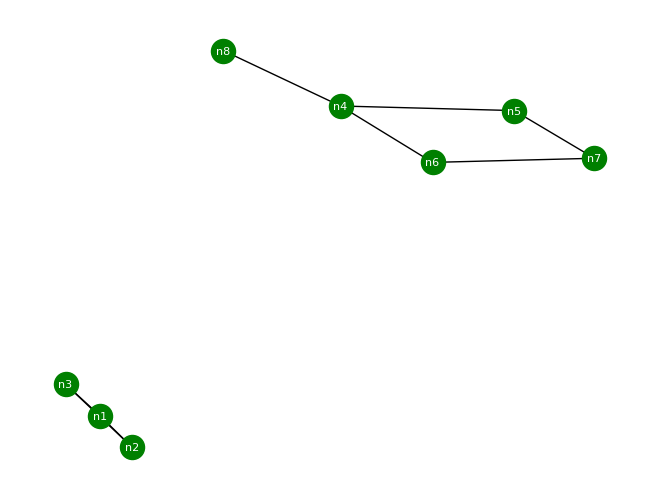

In [15]:
def afficher_graphe(g):
  g_pandas = g.toPandas()

  nlist = pd.concat([g_pandas['s'], g_pandas['d']]).unique()
  elist = g_pandas.to_records(index=False).tolist()

  g_nx = nx.Graph()
  g_nx.add_nodes_from(nlist)
  g_nx.add_edges_from(elist)

  pos = nx.spring_layout(g_nx, iterations = 25)
  nx.draw(g_nx, pos, with_labels="True", node_size=300, font_size='8', node_color= "green", font_color="white")

afficher_graphe(G1)

## Decentralized component calculation

It is assumed that the data in G are distributed in two partitions.
It is assumed that it is not possible to read both partitions to reconstruct the entire graph. In other words, the largest graph that can be read is that of a single partition.

The objective is to determine the components of G.

In [16]:
part0 = """
n1 n2
n3 n1
n7 n5
n4 n6
"""

part1 = """
n7 n6
n4 n5
n4 n8
n2 n3
"""

data = [part0, part1]
G = []

# On considère ici (pour simplifier) que chaque partition est un dataframe séparé

for i in range(2):
  tab = [line.split(" ") for line in data[i].split('\n') if len(line)>0]
  tab = [(s, d) for (s, d) in tab]
  G.append( spark.createDataFrame(tab, ["s", "d"]) )

In [17]:
print("partition P0")
display(G[0])

partition P0


,s,d
0,n1,n2
1,n3,n1
2,n7,n5
3,n4,n6


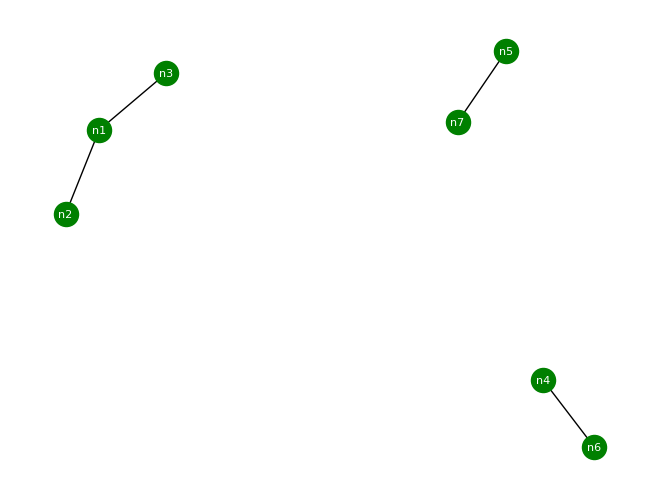

In [18]:
afficher_graphe(G[0])

In [19]:
print("partition P1")
display(G[1])

partition P1


,s,d
0,n7,n6
1,n4,n5
2,n4,n8
3,n2,n3


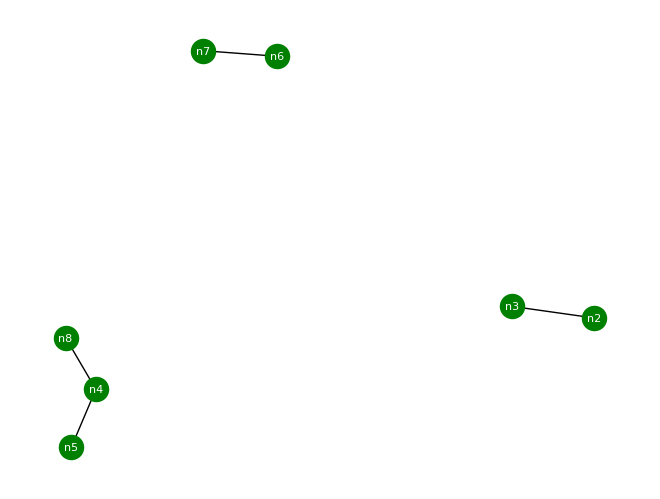

In [20]:
afficher_graphe(G[1])

We start by calculating the components of G separately on each partition P0 and P1.
* G0_comp (partID, n, comp) with partID set to "P0".
* G1_comp (partID, n, comp) with partID set to "P1".

In [21]:
def get_composantes_from_edge_list(edge_list):
  g_ig = ig.Graph(directed=False)

  df = spark.createDataFrame(edge_list, ["s", "d"])
  nodes = df.selectExpr("s as n").union(df.selectExpr("d as n")).distinct().toPandas()
  nlist = [str(n.n) for n in nodes.itertuples(index=False)]

  g_ig.add_vertices(nlist)
  g_ig.add_edges(edge_list)

  components = g_ig.connected_components(mode='weak')

  # # Associer le nom du noeud n avec sa composante comp
  # # On obtient la relation (n, comp)
  vertex_comp = zip(g_ig.vs()["name"], components.membership)
  return [(n,comp) for n,comp in vertex_comp]

In [22]:
edge_lists_0 = [(str(e.s), str(e.d)) for e in G[0].toPandas().itertuples(index=False) ]
edge_lists_1 = [(str(e.s), str(e.d)) for e in G[1].toPandas().itertuples(index=False) ]

compo_0 = get_composantes_from_edge_list(edge_lists_0)
compo_1 = get_composantes_from_edge_list(edge_lists_1)
print(f'Le graphe G0 a pour composantes :{compo_0}')
print(f'Le graphe G1 a pour composantes :{compo_1}')

df = pd.DataFrame([('P0', n[0], n[1]) for n in compo_0], columns = ['partID', 'n', 'comp'])

Le graphe G0 a pour composantes :[('n3', 0), ('n1', 0), ('n7', 1), ('n4', 2), ('n2', 0), ('n5', 1), ('n6', 2)]
Le graphe G1 a pour composantes :[('n7', 0), ('n4', 1), ('n2', 2), ('n6', 0), ('n5', 1), ('n3', 2), ('n8', 1)]


In [23]:
elist_0 = [(str(e.s), str(e.d)) for e in G[0].toPandas().itertuples(index=False) ]
elist_1 = [(str(e.s), str(e.d)) for e in G[1].toPandas().itertuples(index=False) ]

compo_0 = get_composantes_from_edge_list(edge_lists_0)
compo_1 = get_composantes_from_edge_list(edge_lists_1)

print(f'Le graphe G0 a pour composantes :{compo_0}')
print(f'Le graphe G1 a pour composantes :{compo_1}')

G0_Comp = pd.DataFrame([('P0', n[0], n[1]) for n in compo_0], columns = ['partID', 'n', 'comp'])
G0_comp = G0_Comp.to_parquet("composantes_parquet_0")
G0_comp = spark.read.format("parquet").load("composantes_parquet_0")
print("G0_Comp:")
display(G0_comp)

Le graphe G0 a pour composantes :[('n3', 0), ('n1', 0), ('n7', 1), ('n4', 2), ('n2', 0), ('n5', 1), ('n6', 2)]
Le graphe G1 a pour composantes :[('n7', 0), ('n4', 1), ('n2', 2), ('n6', 0), ('n5', 1), ('n3', 2), ('n8', 1)]
G0_Comp:


,partID,n,comp
0,P0,n3,0
1,P0,n1,0
2,P0,n7,1
3,P0,n4,2
4,P0,n2,0
5,P0,n5,1
6,P0,n6,2


In [24]:
G1_Comp = pd.DataFrame([('P1', n[0], n[1]) for n in compo_1], columns = ['partID', 'n', 'comp'])
G1_comp = G1_Comp.to_parquet("composantes_parquet_1")
G1_comp = spark.read.format("parquet").load("composantes_parquet_1")
print("G1_Comp:")
display(G1_comp)

G1_Comp:


,partID,n,comp
0,P1,n7,0
1,P1,n4,1
2,P1,n2,2
3,P1,n6,0
4,P1,n5,1
5,P1,n3,2
6,P1,n8,1


The components calculated in G0_Comp and G1_Comp were obtained independently. Now we want to "associate" them.

In [25]:
display(G0_comp)

,partID,n,comp
0,P0,n3,0
1,P0,n1,0
2,P0,n7,1
3,P0,n4,2
4,P0,n2,0
5,P0,n5,1
6,P0,n6,2


In [26]:
from pyspark.sql.functions import col, when

G0_Comp_unique = G0_Comp[['n', 'comp']].copy()
G0_Comp_unique['comp'] = 'P0_' + G0_Comp_unique['comp'].astype(str)
G0_Comp_unique.to_parquet("composantes_uniques_0")
G0_comp_unique = spark.read.format("parquet").load("composantes_uniques_0")

display(G0_comp_unique)

,n,comp
0,n3,P0_0
1,n1,P0_0
2,n7,P0_1
3,n4,P0_2
4,n2,P0_0
5,n5,P0_1
6,n6,P0_2


In [27]:
G1_comp_unique = G1_Comp[['n', 'comp']].copy()
G1_comp_unique['comp'] = 'P1_' + G1_comp_unique['comp'].astype(str)
G1_comp_unique.to_parquet("composantes_uniques_1")
G1_comp_unique = spark.read.format("parquet").load("composantes_uniques_1")

display(G1_comp_unique)

,n,comp
0,n7,P1_0
1,n4,P1_1
2,n2,P1_2
3,n6,P1_0
4,n5,P1_1
5,n3,P1_2
6,n8,P1_1


We want to determine which nodes are present in several components.
A node can appear in both G0_comp_unique and G1_comp_unique.

However, we can't combine G0_comp_unique and G1_comp_unique
in a single file, as it would be too large (in general, it can contain up to number of nodes * number of line partitions).

So we propose to **distribute**, in several dataframes, the data from G0_comp_unique and G1_comp_unique according to the value of node n.

Separate the data from G0_comp_unique and G1_comp_unique into two dataframes such as:
  **N1_a_N4**(n,comp) contains all lines concerning nodes 1 to 4.
  **N5_a_N8**(n,comp) contains all rows for nodes 5 to 8.

In [28]:
N1_a_N4_0 = G0_comp_unique.select('n', 'comp').where(G0_comp_unique.n.substr(2,1).cast(IntegerType()) <= 4)
N1_a_N4_1 = G1_comp_unique.select('n', 'comp').where(G1_comp_unique.n.substr(2,1).cast(IntegerType()) <= 4)
N1_a_N4 = N1_a_N4_0.union(N1_a_N4_1)
display(N1_a_N4)

,n,comp
0,n3,P0_0
1,n1,P0_0
2,n4,P0_2
3,n2,P0_0
4,n4,P1_1
5,n2,P1_2
6,n3,P1_2


In [29]:
N5_a_N8_0 = G0_comp_unique.select('n', 'comp').where(G0_comp_unique.n.substr(2,1).cast(IntegerType()) > 4)
N5_a_N8_1 = G1_comp_unique.select('n', 'comp').where(G1_comp_unique.n.substr(2,1).cast(IntegerType()) > 4)
N5_a_N8 = N5_a_N8_0.union(N5_a_N8_1)
display(N5_a_N8)

,n,comp
0,n7,P0_1
1,n5,P0_1
2,n6,P0_2
3,n7,P1_0
4,n6,P1_0
5,n5,P1_1
6,n8,P1_1


From the N1_a_N4 relationship, we determine the pairs of components
Comp_edges_a(from, to) that have a common node and such that
  *from* is a component of P0
  * *to* is a component of P1.

Perform the same calculation from N5_a_N8 to obtain Comp_edges_b(from, to).

Then combine the results in a relationship to be called **Comp_edges**(from, to)

In [30]:
df_p0 = N5_a_N8.filter(col("comp").like("P0%"))
df_p1 = N5_a_N8.filter(col("comp").like("P1%"))

result = df_p0.alias('df0').join(df_p1.alias('df1'), col("df0.n") == col("df1.n")).select(
    col("df0.comp").alias("from"),
    col("df1.comp").alias("to")
)

display(result)

,from,to
0,P0_1,P1_1
1,P0_2,P1_0
2,P0_1,P1_0


In [31]:
df_p0 = N5_a_N8.filter(col("comp").like("P0%"))
df_p1 = N5_a_N8.filter(col("comp").like("P1%"))

Comp_edges_a = df_p0.alias('df0').join(df_p1.alias('df1'), col("df0.n") == col("df1.n")).select(
    col("df0.comp").alias("from_comp"),
    col("df1.comp").alias("to_comp")
)

df_p0_ = N1_a_N4.filter(col("comp").like("P0%"))
df_p1_ = N1_a_N4.filter(col("comp").like("P1%"))

Comp_edges_b = df_p0_.alias('df0').join(df_p1_.alias('df1'), col("df0.n") == col("df1.n")).select(
    col("df0.comp").alias("from_comp"),
    col("df1.comp").alias("to_comp")
)

Comp_edges = Comp_edges_a.union(Comp_edges_b)

display(Comp_edges)

,from_comp,to_comp
0,P0_1,P1_1
1,P0_2,P1_0
2,P0_1,P1_0
3,P0_0,P1_2
4,P0_0,P1_2
5,P0_2,P1_1


In [32]:
edge_list = [(str(e.from_comp), str(e.to_comp)) for e in Comp_edges.toPandas().itertuples(index=False) ]

comp_list = get_composantes_from_edge_list(edge_list)
print(f'Le graphe Comp_edges a pour composantes :{comp_list}')

Global_Comp = pd.DataFrame(comp_list, columns = ['comp', 'global_comp'])
Global_Comp.to_parquet("Global_comp")
Global_comp = spark.read.format("parquet").load("Global_comp")

display(Global_comp)

Le graphe Comp_edges a pour composantes :[('P0_1', 0), ('P0_2', 0), ('P0_0', 1), ('P1_0', 0), ('P1_1', 0), ('P1_2', 1)]


,comp,global_comp
0,P0_1,0
1,P0_2,0
2,P0_0,1
3,P1_0,0
4,P1_1,0
5,P1_2,1


We deduce the components of the nodes of G :

In [33]:
composantes_pour_N1_a_N4 = Global_comp.alias("d1").join(N1_a_N4.alias("d2"), col("d1.comp") == col("d2.comp")).select("d2.n", "d1.global_comp").distinct()
print("composantes pour les noeuds n1 à n4 :")
display(composantes_pour_N1_a_N4)

composantes pour les noeuds n1 à n4 :


,n,global_comp
0,n3,1
1,n2,1
2,n1,1
3,n4,0


In [34]:
composantes_pour_N5_a_N8 = Global_comp.alias("d1").join(N5_a_N8.alias("d2"), col("d1.comp") == col("d2.comp")).select("d2.n", "d1.global_comp").distinct()
print("composantes pour les noeuds n5 à n8 :")
display(composantes_pour_N5_a_N8)

composantes pour les noeuds n5 à n8 :


,n,global_comp
0,n8,0
1,n5,0
2,n7,0
3,n6,0


In [35]:
G[0] = G[0].alias("d1").join(composantes_pour_N1_a_N4.union(composantes_pour_N5_a_N8).alias("d2"), col("d1.s") == col("d2.n")).select("d1.s", "d1.d", col("d2.global_comp").alias("comp"))
display(G[0])

,s,d,comp
0,n1,n2,1
1,n3,n1,1
2,n4,n6,0
3,n7,n5,0


In [36]:
G[1] = G[1].alias("d1").join(composantes_pour_N1_a_N4.union(composantes_pour_N5_a_N8).alias("d2"), col("d1.s") == col("d2.n")).select("d1.s", "d1.d", col("d2.global_comp").alias("comp"))
display(G[1])

,s,d,comp
0,n2,n3,1
1,n4,n5,0
2,n4,n8,0
3,n7,n6,0


The aim is to integrate the solution from the previous exercise into Spark, so that it can be processed in parallel as far as possible.
The solution must be general enough to work for n partitions (with n > 2).

Consider the graph G stored in **a single** dataframe made up of **several** partitions.

a) We define a UDF function that calculates the components in a partition.

b) We invoke the UDF function to run in parallel on each partition.

c) From the components of each partition, define the complementary processing to obtain the components of G so that the operations are processed in parallel.

In [41]:
data1 = """
n1 n2
n2 n3
n3 n1
n4 n5
n4 n6
n4 n8
n7 n5
n7 n6
"""

tab = [line.split(" ") for line in data1.split('\n') if len(line)>0]
tab = [(s, d) for (s, d) in tab]
G = spark.createDataFrame(tab, ["s", "d"])

# distribuer les données dans 2 partitions
G = G.repartition(2)
print("G a", G.rdd.getNumPartitions(), "partitions")

G.printSchema()
display(G)

G a 2 partitions
root
 |-- s: string (nullable = true)
 |-- d: string (nullable = true)



,s,d
0,n3,n1
1,n1,n2
2,n4,n8
3,n7,n6
4,n4,n5
5,n2,n3
6,n7,n5
7,n4,n6


The *showPartitions* function displays the first _n_ elements of each partition. The partID attribute is added to the display to distinguish each partition.

In [42]:
#afficher les N premiers_tuples de chaque partition d'un dataframe
def showPartitions(df, N=5, separate=True):
  nb_partitions = df.rdd.getNumPartitions()

  # fonction topN est invoquée sur une partition.
  # topN retourne un itérateur sur une partition qui contient les N premiers éléments de cette partition
  def topN(partID, iterateur):
    c=0
    suivant = next(iterateur, None)
    while suivant is not None and c < N :
      tuple_avec_numero_partition = (partID, *suivant)
      yield tuple_avec_numero_partition
      suivant = next(iterateur, None)
      c+=1

  #-- fin de topN ---


  nom_attributs = ['_partID'] + df.schema.fieldNames()
  premiers_tuples = df.rdd.mapPartitionsWithIndex(topN).toDF(nom_attributs)

  if( separate):
  # afficher séparément le contenu de chaque partition
    for partID in range(nb_partitions):
      print("partition", partID)
      # afficher la partition partID
      premiers_tuples.where(f"_partID={partID}").drop("_partID").show(N, False)
  else:
    # afficher les partitions avec le pseudo attribut _partID
    premiers_tuples.show(N*nb_partitions, False)
    # return display(premiers_tuples, N*nb_partitions)

print('showPartitions définie')

showPartitions définie


Show the partitions.

In [43]:
showPartitions(G)

partition 0
+---+---+
|s  |d  |
+---+---+
|n3 |n1 |
|n1 |n2 |
|n4 |n8 |
|n7 |n6 |
+---+---+

partition 1
+---+---+
|s  |d  |
+---+---+
|n4 |n5 |
|n2 |n3 |
|n7 |n5 |
|n4 |n6 |
+---+---+



In [44]:
# afficher les partitions avec le pseudo attribut _partID
showPartitions(G, separate=False)

+-------+---+---+
|_partID|s  |d  |
+-------+---+---+
|0      |n3 |n1 |
|0      |n1 |n2 |
|0      |n4 |n8 |
|0      |n7 |n6 |
|1      |n4 |n5 |
|1      |n2 |n3 |
|1      |n7 |n5 |
|1      |n4 |n6 |
+-------+---+---+



In [17]:
def calculer_composantes(partID, iterateur):
  nset = set()
  elist = []
  suivant = next(iterateur, None)
  while suivant is not None:
    s, d = suivant
    nset.update([s, d])
    elist.append((s, d))
    suivant = next(iterateur, None)
  nlist = list(nset)

  g_ig = ig.Graph(directed=False)
  g_ig.add_vertices(nlist)
  g_ig.add_edges(elist)

  components = g_ig.connected_components(mode='weak')

  vertex_comp = zip(g_ig.vs()["name"], components.membership)

  for n,comp in vertex_comp:
    yield (f"P{partID}", n,comp)

In [46]:
nom_attributs = ['_partID', 'n', 'comp']
composantes = G.rdd.mapPartitionsWithIndex(calculer_composantes).toDF(nom_attributs)
display(composantes)

,_partID,n,comp
0,P0,n2,0
1,P0,n8,1
2,P0,n1,0
3,P0,n3,0
4,P0,n6,2
5,P0,n7,2
6,P0,n4,1
7,P1,n5,0
8,P1,n2,1
9,P1,n3,1


In [47]:
# Calcul de Comp_edges comme en 1)d)
Comp_edges = composantes.withColumn("_partID_", f.concat(col("_partID"), f.expr("'_'")))\
  .withColumn("comp",f.concat(col("_partID_"), col("comp")))\
  .groupBy("n").pivot("_partID").agg(f.first("comp")).na.drop()\
  .select(col("n"), col("P0").alias("from_comp"), col("P1").alias("to_comp")).distinct()
display(Comp_edges)

,n,from_comp,to_comp
0,n2,P0_0,P1_1
1,n3,P0_0,P1_1
2,n4,P0_1,P1_0
3,n6,P0_2,P1_0
4,n7,P0_2,P1_0


In [48]:
edge_list = Comp_edges.toPandas().to_records(index=False).tolist()
comp_list = get_composantes(Comp_edges.select(col("from_comp").alias("s"),col("to_comp").alias("d")))

print(f"Le graphe Comp_edges a pour composantes :", comp_list)

Global_comp = spark.createDataFrame(comp_list, ["comp", "global_comp"])
display(Global_comp)

Le graphe Comp_edges a pour composantes : [('P0_0', 0), ('P0_1', 1), ('P0_2', 1), ('P1_1', 0), ('P1_0', 1)]


,comp,global_comp
0,P0_0,0
1,P0_1,1
2,P0_2,1
3,P1_1,0
4,P1_0,1


In [51]:
composantes_gl = composantes.withColumn("_partID_", f.concat(col("_partID"), f.expr("'_'")))\
  .withColumn("comp",f.concat(col("_partID_"), col("comp")))\
  .alias("d1").join(Global_comp.alias("d2"), "comp").select("d1.n","d2.global_comp").distinct()
print("Les composantes globales:")
display(composantes_gl)

Les composantes globales:


,n,global_comp
0,n1,0
1,n6,1
2,n4,1
3,n7,1
4,n2,0
5,n3,0
6,n8,1
7,n5,1


## Large-scale calculation
Now, we want to compute the components of "real" protein graphs with a number of arcs ranging from 10,000 to 10 million.

In [14]:
g10K = spark.read.format("parquet").load("/local/data/BDLE_10K").selectExpr("seqID1 as s", "seqID2 as d", "sim").persist()
print(g10K.count())
g10K.printSchema()
display(g10K, 5)

20842
root
 |-- s: string (nullable = true)
 |-- d: string (nullable = true)
 |-- sim: float (nullable = true)



,s,d,sim
0,117761605:5,152890023:5,97.800003
1,152904885:3,155591878:2,88.500000
2,152887848:4,153682181:0,100.000000
3,152937692:5,80009514:2,82.300003
4,152990923:2,154549183:4,98.000000


In [15]:
g1M = spark.read.format("parquet").load("/local/data/BDLE_1M").selectExpr("seqID1 as s", "seqID2 as d", "sim").persist()
print(g1M.count())
g1M.printSchema()
display(g1M, 5)

1768595
root
 |-- s: string (nullable = true)
 |-- d: string (nullable = true)
 |-- sim: float (nullable = true)



,s,d,sim
0,28266027:2,30697475:4,100.000000
1,141099253:1,142374057:2,87.800003
2,100479579:0,23509310:0,83.900002
3,113579361:3,114583521:5,100.000000
4,127898390:3,142186630:2,100.000000


In [62]:
# fonction principale
def calculer_composantes_nPartitions(df, nb_partitions=4, v=False):
    df_pn = repartition_dataframe(df, nb_partitions)
    df_composantes_pn = calculate_components_in_partitions(df_pn, v)
    df_composantes_pn_pivot = pivot_on_part_id(df_composantes_pn, v)
    df_Comp_edges = create_comp_edges(df_composantes_pn_pivot, nb_partitions, v)
    df_Global_comp = calculate_global_components(df_Comp_edges, v)
    df_composantes_gl = join_global_components(df_composantes_pn, df_Global_comp, v)
    return df_composantes_gl

def repartition_dataframe(df, nb_partitions):
    df_ = df.repartition(nb_partitions).cache()
    df_.count()
    return df_

def calculate_components_in_partitions(df, v):
    nom_attributs = ['_partID', 'n', 'comp']
    df_composantes_pn = df.rdd.mapPartitionsWithIndex(calculer_composantes).toDF(nom_attributs)
    if v:
        print("Affichage des premiers éléments de chaque partition")
        showPartitions(df, separate=False)
        print("Nombre de tuples dans chaque partition:")
        df_composantes_pn.groupBy("_partID").agg(f.count("*")).show()

        print("Nombre de composantes différentes dans chaque partition")
        df_composantes_pn.groupby("_partID").agg(f.countDistinct(col("comp"))).select("*").show()
    return df_composantes_pn

def pivot_on_part_id(df, v):
    df_composantes_pn_pivot = df.withColumn("_partID_", f.concat(f.col("_partID"), f.expr("'_'")))\
        .withColumn("comp", f.concat(f.col("_partID_"), f.col("comp")))\
        .groupBy("n").pivot("_partID").agg(f.first("comp"))
    if v:
        print("Pivotage sur la colonne _partID")
        df_composantes_pn_pivot.show(10, False)
    return df_composantes_pn_pivot

def create_comp_edges(df_pivot, nb_partitions, v):
    df_Comp_edges = None
    for pi in range(nb_partitions):
        for pj in range(1 + pi, nb_partitions):
            df_Comp_edges_pi_pj = create_comp_edges_for_partition_pair(df_pivot, pi, pj)
            df_Comp_edges = union_dataframes(df_Comp_edges, df_Comp_edges_pi_pj)
    df_Comp_edges = df_Comp_edges.distinct()
    if v:
        print("Table Comp edges")
        df_Comp_edges.show(10, False)
    return df_Comp_edges

def create_comp_edges_for_partition_pair(df_pivot, pi, pj):
    return df_pivot\
        .select(f.col("n"), f.col(f"P{pi}").alias("from_comp"), f.col(f"P{pj}").alias("to_comp"))\
        .withColumn("from_comp", f.when(f.col("from_comp").isNull(), f.col("to_comp")).otherwise(f.col("from_comp")))\
        .withColumn("to_comp", f.when(f.col("to_comp").isNull(), f.col("from_comp")).otherwise(f.col("to_comp")))\
        .dropna()

def union_dataframes(df1, df2):
    if df1 is None:
        return df2
    else:
        return df1.unionByName(df2, allowMissingColumns=True)

def calculate_global_components(df_Comp_edges, v):
    comp_list = get_composantes(df_Comp_edges.select(f.col("from_comp").alias("s"), f.col("to_comp").alias("d")))
    df_Global_comp = spark.createDataFrame(comp_list, ["comp", "global_comp"])
    if v:
        print("Global edges comp")
        df_Global_comp.show(10, False)
    return df_Global_comp

def join_global_components(df_composantes_pn, df_Global_comp, v):
    df_composantes_gl = df_composantes_pn.withColumn("_partID_", f.concat(f.col("_partID"), f.expr("'_'")))\
        .withColumn("comp", f.concat(f.col("_partID_"), f.col("comp")))\
        .alias("t1").join(df_Global_comp.alias("t2"), "comp").select("t1.n", "t2.global_comp").distinct()
    if v:
        print("composantes global unifiée:")
        df_composantes_gl.show(10, False)
    return df_composantes_gl

In [63]:
g10K_composantes_2p = calculer_composantes_nPartitions(g10K.select("s","d"), nb_partitions=2, v=True)

Affichage des premiers éléments de chaque partition
+-------+-----------+---------------------------------+
|_partID|s          |d                                |
+-------+-----------+---------------------------------+
|0      |102909980:0|82547823:5                       |
|0      |135688826:0|142273124:4                      |
|0      |19919949:4 |81071024:3                       |
|0      |44890806:2 |53954341:5                       |
|0      |142280050:5|142280051:5                      |
|1      |89787408:2 |90725987:5                       |
|1      |133219985:1|158317061:2                      |
|1      |116925681:2|METdb_00224-1-DN38546-c0-g5-i1.p1|
|1      |103786036:4|41004824:4                       |
|1      |148830954:2|4382889:3                        |
+-------+-----------+---------------------------------+

Nombre de tuples dans chaque partition:
+-------+--------+
|_partID|count(1)|
+-------+--------+
|     P0|   13075|
|     P1|   13172|
+-------+--------+

Nombre d

In [65]:
# Comparer le temps de calcul pour des nb_partitions partant de 2 à 10
def calculate_and_measure_time(df, nb_partitions, v=False):
    start_time = time.time()
    result_df = calculer_composantes_nPartitions(df, nb_partitions=nb_partitions, v=v)
    elapsed_time = time.time() - start_time
    return result_df, elapsed_time

results = []
times = []

for nb_partitions in range(2, 10):
    print(f"\nRésulats et temps de calcul pour nb_partitions = {nb_partitions}:\n")

    result_df, elapsed_time = calculate_and_measure_time(g10K.select("s", "d"), nb_partitions=nb_partitions, v=False)

    # Append results and times
    results.append(result_df)
    times.append(elapsed_time)

    # Display the results and time
    result_df.show()
    print(f"\nLe temps pris: {elapsed_time} secondes")


Résulats et temps de calcul pour nb_partitions = 2:

+-----------+-----------+
|          n|global_comp|
+-----------+-----------+
| 80348448:1|        268|
|  8924968:4|        268|
| 27353379:1|        268|
| 87794094:3|        268|
| 57315426:5|       3570|
| 20007621:0|       3570|
| 94540941:5|       3570|
| 86655193:0|       2665|
|156511208:1|       3322|
| 16195924:1|       3478|
|  7467289:5|       3478|
|153205178:3|       3179|
|114526814:2|        495|
|109689802:2|        444|
|132642247:4|       1168|
|137293688:1|       1168|
|153819375:5|       2701|
| 38724408:4|       3583|
| 46012998:5|       3583|
| 24652474:2|        699|
+-----------+-----------+
only showing top 20 rows


Le temps pris: 3.3895347118377686 secondes

Résulats et temps de calcul pour nb_partitions = 3:

+-----------+-----------+
|          n|global_comp|
+-----------+-----------+
| 80348448:0|         81|
|  8924968:5|         81|
| 57315426:3|       1512|
| 85530841:0|       1512|
| 57315426:5|   

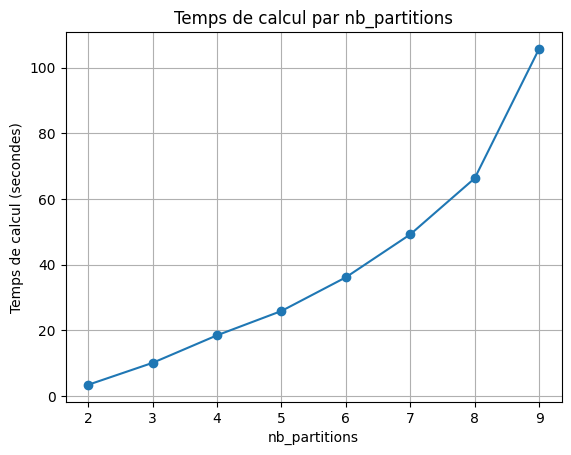

In [66]:
# On plot les résultats
import matplotlib.pyplot as plt

nb_partitions_values = list(range(2, 10))

plt.plot(nb_partitions_values, times, marker='o', linestyle='-')
plt.title('Temps de calcul par nb_partitions')
plt.xlabel('nb_partitions')
plt.ylabel('Temps de calcul (secondes)')
plt.grid(True)
plt.show()

In [68]:
results_ = []
times_ = []

for nb_partitions in range(2, 5):
    print(f"\nRésulats et temps de calcul pour nb_partitions = {nb_partitions}:\n")

    result_df_, elapsed_time_ = calculate_and_measure_time(g1M.select("s", "d"), nb_partitions=nb_partitions, v=True)

    # Append results and times
    results_.append(result_df_)
    times_.append(elapsed_time_)

    # Display the results and time
    result_df_.show()
    print(f"\nLe temps pris: {elapsed_time_} secondes")


Résulats et temps de calcul pour nb_partitions = 2:

Affichage des premiers éléments de chaque partition
+-------+----------------------------+--------------------------------------+
|_partID|s                           |d                                     |
+-------+----------------------------+--------------------------------------+
|0      |72443221:1                  |TARA_RED_19_MAG_00059_000000022885.1.1|
|0      |21847728:0                  |43105288:5                            |
|0      |17785847:2                  |METdb_00307-1-DN7043-c0-g1-i1.p1      |
|0      |EukProt-v2_CAMPEP_0116842978|METdb_00114-1-Transcript-11788.p2     |
|0      |116602082:0                 |132176428:3                           |
|1      |153199036:1                 |26021640:1                            |
|1      |65484232:0                  |76991838:2                            |
|1      |EukProt-v2_c7402_g1_i3.p1   |EukProt-v2_c7402_g1_i4.p1             |
|1      |70067373:1                 

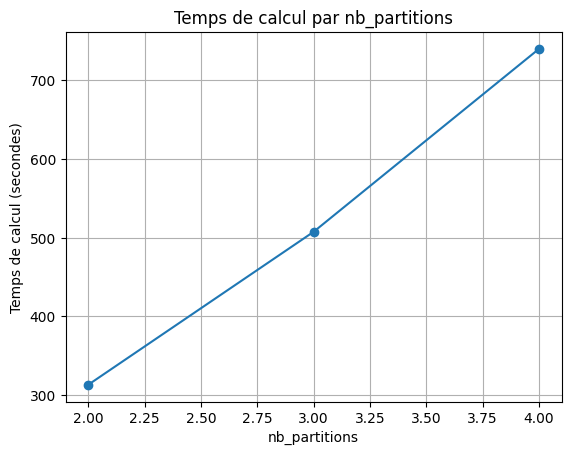

In [69]:
# On plot les résultats
import matplotlib.pyplot as plt

nb_partitions_values = list(range(2, 5))

plt.plot(nb_partitions_values, times_, marker='o', linestyle='-')
plt.title('Temps de calcul par nb_partitions')
plt.xlabel('nb_partitions')
plt.ylabel('Temps de calcul (secondes)')
plt.grid(True)
plt.show()

## Choosing the minimum for the component number

In [1]:
# fonction principale
def calculer_composantes_graphe_numerote(df, v=False):
    df_composantes_pn = calculate_components_partitioned(df)
    df_composantes_pn_nmin = calculate_min_n(df_composantes_pn)
    df_composantes_pn = merge_min_n(df_composantes_pn, df_composantes_pn_nmin, v)
    df_composantes_pn = find_joins(df_composantes_pn, v)

    return df_composantes_pn

def numeroter_noeuds(df, v=False):
  df_s = df.selectExpr("s as n")
  df_d = df.selectExpr("d as n")
  df_n = df_s.unionByName(df_d, allowMissingColumns=True).distinct()

  windowSpec = Window.orderBy(col("n"))

  df_n = df_n.withColumn("Rank", f.rank().over(windowSpec))
  df_ns = df.alias("t1").join(df_n.alias("t2"), col("t1.s") == col("t2.n"), "left_outer")\
            .select(col("Rank").alias("s"), col("d"))
  df_ns_nd = df_ns.alias("t1").join(df_n.alias("t2"), col("t1.d") == col("t2.n"), "left_outer")\
            .select(col("s").cast("string"), col("Rank").alias("d").cast("string"))

  if v:
    df_ns_nd.show(10, False)

  return df_ns_nd

def calculate_components_partitioned(df):
    nom_attributs = ['_partID', 'n', 'comp']
    df_composantes_pn = df.rdd.mapPartitionsWithIndex(calculer_composantes).toDF(nom_attributs)
    return df_composantes_pn

def calculate_min_n(df_composantes_pn):
    df_composantes_pn_nmin = df_composantes_pn.groupBy(col("_partID"), col("comp")) \
        .agg(f.min(col("n")).alias("nmin"))
    return df_composantes_pn_nmin

def merge_min_n(df_composantes_pn, df_composantes_pn_nmin, v=False):
    df_composantes_pn = df_composantes_pn.alias("t1") \
        .join(df_composantes_pn_nmin.alias("t2"), \
              (col("t1._partID") == col("t2._partID")) & (col("t1.comp") == col("t2.comp")), \
              "left_outer") \
        .select(col("t1._partID"), "t1.n", col("t1.comp"), "t2.nmin")

    if v:
        print("Nombre de composantes différentes dans chaque partition")
        df_composantes_pn.groupby("_partID").agg(f.countDistinct(col("comp"))).select("*").show()
        df_composantes_pn.show(10, False)

    return df_composantes_pn

def find_joins(df_composantes_pn, v=False):
    ok = False
    while not ok:
        df_joins = df_composantes_pn.alias("t1").join(df_composantes_pn.alias("t2"), \
                                                      (col("t1.n") == col("t2.n")) & \
                                                      (col("t1._partID") != col("t2._partID")) & \
                                                      (col("t1.nmin") != col("t2.nmin")), "inner") \
            .select(col("t1.n"), \
                    f.when(col("t1.nmin") < col("t2.nmin"), col("t1._partID")) \
                    .otherwise(col("t2._partID")).alias("min_nmin_partID"), \
                    f.when(col("t1.nmin") < col("t2.nmin"), col("t1.nmin")) \
                    .otherwise(col("t2.nmin")).alias("min_nmin"), \
                    f.when(col("t1.nmin") < col("t2.nmin"), col("t2._partID")) \
                    .otherwise(col("t1._partID")).alias("max_nmin_partID"), \
                    f.when(col("t1.nmin") < col("t2.nmin"), col("t2.nmin")) \
                    .otherwise(col("t1.nmin")).alias("max_nmin")).distinct()

        if v:
            print("Les points joins entre deux partitions")
            df_joins.show(10, False)
        df_joins.selectExpr("count (*) nb_joins").show()
        if df_joins.isEmpty():
            break

        df_composantes_pn = update_composantes_pn(df_composantes_pn, df_joins)

    return df_composantes_pn

def update_composantes_pn(df_composantes_pn, df_joins):
    df_composantes_pn = df_composantes_pn.alias("t1") \
        .join(df_joins.alias("t2"), \
              (col("t1._partID") == col("t2.max_nmin_partID")) & \
              (col("t1.n") == col("t2.n")) & \
              (col("t1.nmin") == col("t2.max_nmin")), "left_outer") \
        .select(col("t1._partID"), col("t1.n"), col("t1.nmin"), col("t2.min_nmin")) \
        .groupBy(col("_partID"), col("n"), col("t1.nmin")) \
        .agg(f.min(col("min_nmin")).alias("min_nmin_gl")) \
        .withColumn("min_nmin_gl", f.when(col("min_nmin_gl").isNull(), col("nmin")) \
                                    .otherwise(col("min_nmin_gl"))) \
        .select(col("_partID"), col("n"), col("min_nmin_gl").alias("nmin"))
    return df_composantes_pn

In [18]:
nb_partitions = 4
g10K_n = numeroter_noeuds(g10K, False).repartition(nb_partitions)

df_gl = calculer_composantes_graphe_numerote(g10K_n, False)

Merging nmin
+--------+
|nb_joins|
+--------+
|   11226|
+--------+

Fin Merging nmin
Merging nmin
+--------+
|nb_joins|
+--------+
|       0|
+--------+



In [22]:
display(df_gl)

,_partID,n,nmin
0,P0,1,1
1,P0,100,100
2,P0,1000,1000
3,P0,10001,10001
4,P0,10004,10004
...,...,...,...
95,P0,1021,1021
96,P0,10210,10210
97,P0,10216,10216
98,P0,10217,10217
